In [390]:
import tropycal.tracks as tracks
from useful_functions import create_genesis_grid_labels
import numpy as np
import xarray as xr
from scipy.ndimage import gaussian_filter
from scipy.ndimage import median_filter
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import skimage.measure as ms
import scipy.ndimage as nd

In [5]:
# # Time ranges for EVERYTHING desired
month_range = np.arange(6,12,1)
test_years = np.arange(2005,2021,1)
train_years = np.arange(1950,2005,1)
train_years = np.setdiff1d(train_years, np.arange(1971,1979,1))
Latitude=np.arange(0,80,2)
Longitude=np.arange(260,360,2)

# # Grab ibtracs data (uncomment this section if you want to recreate genesis (observed) labels, otherwise it is already saved)
# basin_dataset = tracks.TrackDataset(basin='north_atlantic',source='ibtracs',include_btk=True)

# # Create genesis labels from ibtracs data (slowest step)
# vmin=0
# print('Training Dataset')
# train_labels_predropped = create_genesis_grid_labels(month_range,train_years,vmin,basin_dataset)
# print('Testing Dataset')
# test_labels_predropped = create_genesis_grid_labels(month_range,test_years,vmin,basin_dataset)

# train_labels_predropped.unstack().to_netcdf("/glade/work/acheung/Initial_RF_Datasets/train_labels_predropped.nc")
# test_labels_predropped.unstack().to_netcdf("/glade/work/acheung/Initial_RF_Datasets/test_labels_predropped.nc")

--> Starting to read in ibtracs data
--> Completed reading in ibtracs data (5.37 seconds)
--> Starting to read in best track data
--> Completed reading in best track data (0.22 seconds)
Training Dataset


/glade/u/home/acheung/TC_Genesis_Index/Scripts/useful_functions.py:53: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  gen_by_month = szn_DF_starts.loc[str(dt(year=year_desired,
/glade/u/home/acheung/TC_Genesis_Index/Scripts/useful_functions.py:53: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  gen_by_month = szn_DF_starts.loc[str(dt(year=year_desired,
/glade/u/home/acheung/TC_Genesis_Index/Scripts/useful_functions.py:53: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  gen_by_month = szn_DF_starts.loc[str(dt(year=year_desired,
/glade/u/home/acheung/TC_Genesis_Index/Scripts/useful_functions.py:53: FutureWarning: Value based partial slicing on non-mon

Testing Dataset


/glade/u/home/acheung/TC_Genesis_Index/Scripts/useful_functions.py:53: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  gen_by_month = szn_DF_starts.loc[str(dt(year=year_desired,
/glade/u/home/acheung/TC_Genesis_Index/Scripts/useful_functions.py:53: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  gen_by_month = szn_DF_starts.loc[str(dt(year=year_desired,
/glade/u/home/acheung/TC_Genesis_Index/Scripts/useful_functions.py:53: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  gen_by_month = szn_DF_starts.loc[str(dt(year=year_desired,
/glade/u/home/acheung/TC_Genesis_Index/Scripts/useful_functions.py:53: FutureWarning: Value based partial slicing on non-mon

In [8]:
train_labels_predropped_read = xr.open_dataset("/glade/work/acheung/Initial_RF_Datasets/train_labels_predropped.nc")
train_labels_predropped = train_labels_predropped_read.stack(z=("Month","Latitude","Longitude","Year"))

test_labels_predropped_read = xr.open_dataset("/glade/work/acheung/Initial_RF_Datasets/test_labels_predropped.nc")
test_labels_predropped = test_labels_predropped_read.stack(z=("Month","Latitude","Longitude","Year"))

/glade/u/home/acheung/.conda/envs/snowflakes/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:1785: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = super().pcolormesh(*args, **kwargs)
/glade/scratch/acheung/ipykernel_212892/2282640230.py:17: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  cbar = plt.colorbar(filtered_month_plot)


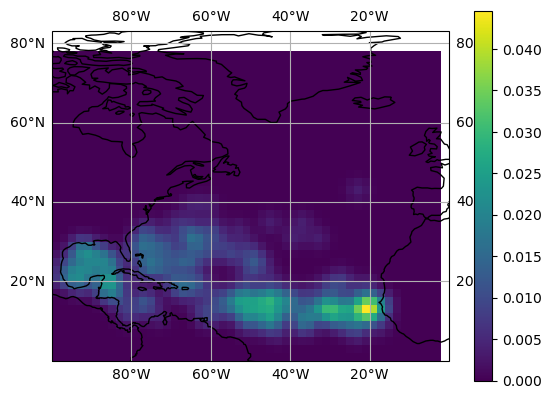

In [539]:
climo_month_label = train_labels_predropped_read.sel(Month=9).to_array()[0]
climo_mean_month_label = np.mean(climo_month_label,axis=2)
climo_filtered_month = gaussian_filter(mean_month_label, sigma=1)
climo_filtered_month_with_coords = xr.DataArray(climo_filtered_month, coords=[mean_month_label.coords['Latitude'],mean_month_label.coords['Longitude']])

# Monthly Climatological Plot (Monthly Mean Performed)

plt.figure()
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global()
ax.coastlines()
ax.gridlines(draw_labels=True)
climo_filtered_month_plot = ax.pcolormesh(climo_filtered_month_with_coords.coords['Longitude'],
                                    climo_filtered_month_with_coords.coords['Latitude'],
                                    climo_filtered_month_with_coords,transform=ccrs.PlateCarree(),vmin=0)
ax.set_extent([-100, 0, 0, 80])
cbar = plt.colorbar(filtered_month_plot)
plt.savefig('climo')


/glade/u/home/acheung/.conda/envs/snowflakes/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:1785: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = super().pcolormesh(*args, **kwargs)


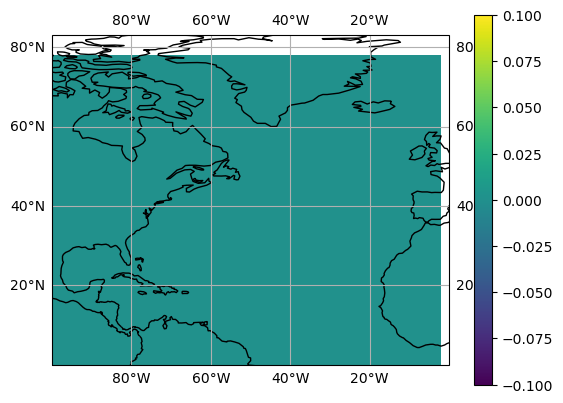

In [537]:
interval = 1 # pooling size (1 is no pooling)

trainlabelpoints_pooled = xr.DataArray(skimage.measure.block_reduce(train_labels_predropped_read.to_array()[0], (1,interval,interval,1),np.nansum),
             coords=[train_labels_predropped_read.coords['Month'],
                     train_labels_predropped_read.coords['Latitude'][::interval],
                    train_labels_predropped_read.coords['Longitude'][::interval],
                     train_labels_predropped_read.coords['Year']])

viewfilt = gaussian_filter(trainlabelpoints_pooled.sel(Month=9,Year=2000),sigma=15)

ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global()
ax.coastlines()
ax.gridlines(draw_labels=True)
contourplot = ax.pcolormesh(train_labels_predropped_read.coords['Longitude'][::interval],
                           train_labels_predropped_read.coords['Latitude'][::interval],viewfilt,transform=ccrs.PlateCarree())
ax.set_extent([-100, 0, 0, 80])
cbar = plt.colorbar(contourplot)
plt.savefig('test')
# testlabelpoints_pooled_masked = testlabelpoints_pooled.where(isnan_pool != 0)

In [525]:
viewfilt

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

/glade/u/home/acheung/.conda/envs/snowflakes/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:1785: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = super().pcolormesh(*args, **kwargs)


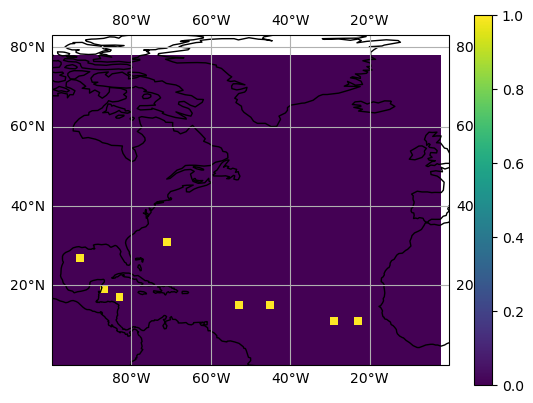

In [486]:
ax2 = plt.axes(projection=ccrs.PlateCarree())
ax2.set_global()
ax2.coastlines()
ax2.gridlines(draw_labels=True)
ax2.set_extent([-100, 0, 0, 80])
verifyplot = ax2.pcolormesh(train_labels_predropped_read.coords['Longitude'],
               train_labels_predropped_read.coords['Latitude'],
               train_labels_predropped_read.sel(Month=9,Year=2000).to_array()[0],transform=ccrs.PlateCarree())
cbar = plt.colorbar(verifyplot)


In [428]:
train_labels_predropped_read.sel(Month=9,Year=2000).to_array()[0]

<xarray.DataArray (Latitude: 40, Longitude: 50)>
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)
Coordinates:
  * Longitude  (Longitude) int32 260 262 264 266 268 270 ... 350 352 354 356 358
    Year       int32 2000
  * Latitude   (Latitude) int32 0 2 4 6 8 10 12 14 ... 64 66 68 70 72 74 76 78
    Month      int32 9
    variable   <U29 '__xarray_dataarray_variable__'

In [404]:
contourplot.get_paths

AttributeError: 'QuadContourSet' object has no attribute 'get_paths'

In [306]:
contourplot.get_transform

<bound method ContourSet.get_transform of <matplotlib.contour.QuadContourSet object at 0x2ad67ee31de0>>